# SLEAP Feature Extraction for Home Cage

### <b> This notebook is used to extract sleap-based features from a trial level (multiple mice) <b>

Features that will be extracted:
- head distance
- res head-int head angle
- res head-int hind distance
- res head-int hind angle
- int head-res hind distance
- int head-res hind angle
- hind distance
- resident velocity
- inrtuder velocity

Need to grab when a intruder is in and the identity of the intruder for downstream analysis

Extra Features to include:
- Brain region
- mouse identity
- standard zscored DA
- Intuder social identity

Convert h5 file data to only include times when another intruder is in

Convert frames to time to be able to line up DA values to times

Extract features from frames

In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

import h5py
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from bouts_extension import *
from slp_trl_class import SleapTrial

In [2]:
file = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\SLEAP\all_tdt\pp8-250121-142227"
csv_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\SLEAP\all_csvs\pp8-250121-142227.csv"
corner_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\SLEAP\corner_sleap\corners.v001.015_1_19_25_Home_Cage_C3-250118-111408_pp8-250121-142227_Cam1_converted.analysis.h5"

video_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\SLEAP\1_19_25_Home_Cage_C3-250118-111408_pp8-250121-142227_Cam1_converted.mp4"

In [3]:
trial = SleapTrial(file, '_465A', '_405A')

Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\SLEAP\all_tdt\pp8-250121-142227\Notes.txt
read from t=0s to t=1871.97s


In [4]:
bout_definitions = [
    {'prefix': 'Short_Term', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
    {'prefix': 'Long_Term', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
    {'prefix': 'Novel', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
]
trial.extract_bouts_and_behaviors(csv_path, bout_definitions, first_only=False)
trial.combine_consecutive_behaviors(behavior_name='all', bout_time_threshold=1)

In [5]:
trial.downsample(target_fs = 100)

# 2.5) Remove beginning and end
trial.remove_initial_LED_artifact(t=30)
trial.remove_final_data_segment(t=10)

# 3) low‐pass
trial.lowpass_filter(cutoff_hz=3.0)

# 4) high‐pass recentered
trial.baseline_drift_highpass_recentered(cutoff=0.001)

# 5) IRLS fit
trial.motion_correction_align_channels_IRLS(IRLS_constant=1.4)

# 6) compute dF/F
trial.compute_dFF()

# 7) zscore
trial.compute_zscore(method='standard')

Sleap

In [6]:
# filename = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\SLEAP\sleap_id_corrected\da_round_2 final (2) copy.008_1_19_25_Home_Cage_C3-250118-111408_pp1-250120-094415_Cam1_converted.analysis.h5"
# filename = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\SLEAP\sleap_id_corrected\da_round_2 final (2) copy.008_1_19_25_Home_Cage_C3-250118-111408_pp1-250120-094415_Cam1_converted.analysis.h5"
filename = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\SLEAP\sleap_id_corrected\da_round_2 final (2) copy.012_1_19_25_Home_Cage_C3-250118-111408_pp5-250121-110144_Cam1_converted.analysis.h5"
trial.load_sleap(h5_path=filename, fps = 10)

In [7]:
trial.calibrate_from_corners(
    corner_h5_path=corner_path,
    real_width_cm=32,
    top_left="Top_Left",
    top_right="Top_Right"
)

0.083040414644066

In [8]:
trial.filter_sleap_bouts(interp_kind="linear")

In [9]:
trial.smooth_locations()

In [10]:
trial.node_dict

{'Head': 0,
 'Right_Ear': 1,
 'Nose': 2,
 'Tail_Base': 3,
 'Left_Lateral': 4,
 'Right_Lateral': 5,
 'Left_Ear': 6,
 'Neck': 7,
 'Center': 8}

In [11]:
trial.track_dict

{'subject': 0, 'agent': 1, 'track_1': 2}

Adding DA and metadata

In [12]:
trial.add_metadata_and_DA()

,time_s,brain_region,mouse_identity,zscore_DA,intruder_identity
0,185.2,mPFC,pp8,0.279553,Short_Term-1
1,185.3,mPFC,pp8,0.171266,Short_Term-1
2,185.4,mPFC,pp8,-0.285045,Short_Term-1
3,185.5,mPFC,pp8,0.094867,Short_Term-1
4,185.6,mPFC,pp8,0.419848,Short_Term-1
...,...,...,...,...,...
15107,1803.7,mPFC,pp8,-0.553901,Short_Term-2
15108,1803.8,mPFC,pp8,0.135497,Short_Term-2
15109,1803.9,mPFC,pp8,0.513378,Short_Term-2
15110,1804.0,mPFC,pp8,0.454459,Short_Term-2


Elipse confirmation

In [13]:
# Video loading
trial.load_video(video_path=video_path)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def sample_and_plot_interaction_frames(trial,
                                       a_cm: float = 5.0,
                                       b_cm: float = 3.0,
                                       n_pos: int = 3,
                                       n_neg: int = 3,
                                       center_node: str = 'Head',
                                       angle_src: str  = 'Tail_Base',
                                       angle_dst: str  = 'Nose'):
    """
    Samples n_pos “interaction” frames (mask=True) and n_neg “no-interaction”
    frames (mask=False), then plots them in a 2×max(n_pos,n_neg) grid.
    """

    # 1) compute the per-frame mask
    mask = trial.agent_nose_in_subject_ellipse(a_cm, b_cm,
                                               center_node=center_node,
                                               angle_src=angle_src,
                                               angle_dst=angle_dst)
    pos_idxs = np.where(mask)[0]
    neg_idxs = np.where(~mask)[0]

    # 2) sample (without replacement, but safe if fewer frames exist)
    pos_samples = np.random.choice(pos_idxs, min(n_pos, len(pos_idxs)), replace=False)
    neg_samples = np.random.choice(neg_idxs, min(n_neg, len(neg_idxs)), replace=False)

    # 3) make the figure
    cols = max(len(pos_samples), len(neg_samples))
    fig, axes = plt.subplots(2, cols, figsize=(4*cols, 8))
    axes = axes if cols>1 else axes.reshape(2,1)

    def _plot_cell(ax, frame_i, title):
        frame = trial.get_frame(frame_i)  # your method to fetch the raw H×W×3 image
        ax.imshow(frame)
        # ellipse overlay
        C = trial._xy(center_node,'subject')[frame_i]
        V = trial._vec(angle_src, angle_dst,'subject')[frame_i]
        theta = np.degrees(np.arctan2(V[1], V[0]))
        if trial.px_to_cm:
            a_px, b_px = a_cm / trial.px_to_cm, b_cm / trial.px_to_cm
        else:
            a_px, b_px = a_cm, b_cm
        ell = Ellipse(xy=C, width=2*a_px, height=2*b_px,
                      angle=theta, edgecolor='lime', fill=False, lw=2)
        ax.add_patch(ell)
        # intruder nose
        Pn = trial._xy('Nose','agent')[frame_i]
        ax.scatter(*Pn, c='yellow', s=50, edgecolor='black')
        ax.set(title=f"{title}\nframe {frame_i}", xticks=[], yticks=[])

    # 4) plot positives
    for i, fi in enumerate(pos_samples):
        _plot_cell(axes[0, i], fi, "SOCIAL")
    # 5) plot negatives
    for i, fi in enumerate(neg_samples):
        _plot_cell(axes[1, i], fi, "NO SOCIAL")

    # 6) blank out any unused cells
    for r in [0,1]:
        for c in range(len(pos_samples), cols):
            axes[r, c].axis('off')

    plt.tight_layout()
    plt.show()

# — example usage —
sample_and_plot_interaction_frames(trial, a_cm=5, b_cm=3)


AttributeError: 'SleapTrial' object has no attribute 'agent_nose_in_subject_ellipse'

In [ ]:
df = trial.compute_pairwise_features()

In [ ]:
df = trial.add_behavior_column(df, time_col="time_s",
                               out_col="behavior_active",
                               mode="all")

count              1088
unique                2
top       Investigation
freq               1078
Name: behavior_active, dtype: object


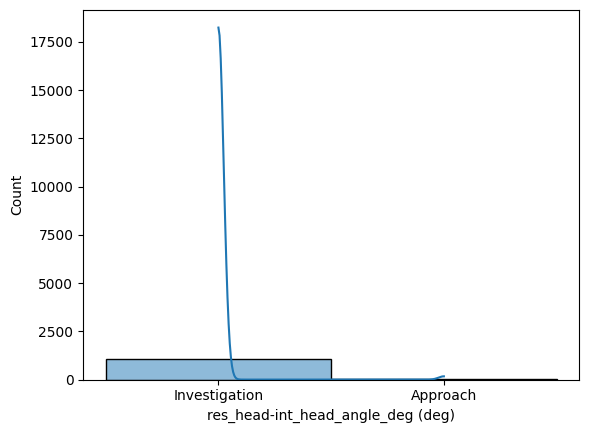

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
col = df['behavior_active'].dropna()

# Quick look
print(col.describe())

# Histogram + density curve
sns.histplot(col, bins=50, kde=True)
plt.xlabel('res_head-int_head_angle_deg (deg)')
plt.show()

DA

In [ ]:
# trial.downsample(target_fs = 100)
# # 2.5) Remove beginning and end
# trial.remove_initial_LED_artifact(t=30)
# trial.remove_final_data_segment(t=10)
# # 3) low‐pass
# trial.lowpass_filter(cutoff_hz=3.0)
# # 4) high‐pass recentered
# trial.baseline_drift_highpass_recentered(cutoff=0.001)
# # 5) IRLS fit
# trial.motion_correction_align_channels_IRLS(IRLS_constant=1.4)
# # 6) compute dF/F
# trial.compute_dFF()
# # 7) zscore
# trial.compute_zscore(method='standard')

Sanity Checks - make sure calculations are correct

In [ ]:
import numpy as np

# parameters
fps = 10.0
F   = 50
d   = 42.0

# make a dummy SleapTrial‐like object
class Dummy:
    pass

t = Dummy()
t.frame_times   = np.arange(F)/fps
# shape = (frames, nodes, dims, instances)
# here we only need 1 node, 2 instances
t.locations = np.zeros((F, 1, 2, 2))
for f in range(F):
    t.locations[f,0,0,0] = 0    # subj x
    t.locations[f,0,1,0] = 0    # subj y
    t.locations[f,0,0,1] = d    # agn x
    t.locations[f,0,1,1] = 0    # agn y

t.node_dict  = {'nose':0}
t.track_dict = {'subject':0, 'agent':1}

# now call your distance_between
dist = SleapTrial.distance_between(t,
           node1='nose', track1='subject',
           node2='nose', track2='agent')

print("mean dist:", np.mean(dist))
print("expected :", d)


AttributeError: 'Dummy' object has no attribute 'px_to_cm'

In [ ]:
import numpy as np

# parameters
fps   = 10.0
F     = 100                 # 10 s of data
v_true = np.array([2.0,3.0])  # px/s

# build a dummy SleapTrial-like object
class Dummy:
    pass

t = Dummy()
t.frame_times = np.arange(F)/fps

# monkey‐patch a single node, single instance into t.locations
# shape must be (frames, nodes, dims, instances)
t.locations = np.zeros((F, 1, 2, 1))
for f in range(F):
    t.locations[f,0,:,0] = v_true * t.frame_times[f]

# build node_dict so our routine finds it
t.node_dict = {'dummy':0}
t.track_dict = {'inst':0}

# plug in the node_velocity from above
def node_velocity(t, node):
    idx    = t.node_dict[node]
    coords = t.locations[:, idx, :, :]       # (F,2,1)
    dt     = np.mean(np.diff(t.frame_times))
    out    = []
    for i in range(coords.shape[-1]):
        xy = coords[...,i]                   # (F,2)
        dx = np.gradient(xy[:,0], dt)
        dy = np.gradient(xy[:,1], dt)
        out.append(np.sqrt(dx*dx + dy*dy))
    return np.stack(out,0)

vel = node_velocity(t, 'dummy')  # shape (1,F)

print("mean computed speed:", vel.mean())
print("expected speed     :", np.linalg.norm(v_true))
# should be within a few 1e‑3 pct or so


mean computed speed: 3.6055512754639887
expected speed     : 3.605551275463989


Understanding h5 files

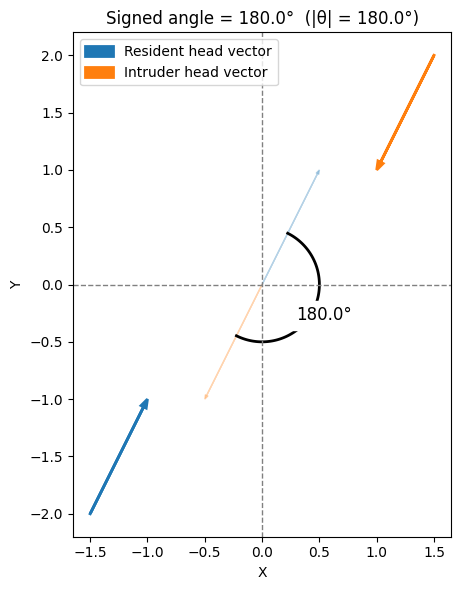

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_head_angle(
    nose_res, earL_res, earR_res,
    nose_int, earL_int, earR_int,
    arc_radius=0.5,              # radius of the arc showing the angle
    vector_color_res='tab:blue',
    vector_color_int='tab:orange',
    arc_color='black',
    figsize=(6,6)
):
    """
    Given nose and ear coordinates for resident and intruder mice,
    compute their head-vectors and plot them, showing the angle between.
    
    nose_res, earL_res, earR_res: (2,) arrays for resident
    nose_int, earL_int, earR_int: (2,) arrays for intruder
    """

    # Compute head vectors (nose minus midpoint of ears)
    ear_mid_res = (np.array(earL_res) + np.array(earR_res)) / 2
    ear_mid_int = (np.array(earL_int) + np.array(earR_int)) / 2

    v_res = np.array(nose_res) - ear_mid_res
    v_int = np.array(nose_int) - ear_mid_int

    # signed angle (degrees) from v_res → v_int
    cross = v_res[0]*v_int[1] - v_res[1]*v_int[0]
    dot   = np.dot(v_res, v_int)
    signed_angle = np.degrees(np.arctan2(cross, dot))
    abs_angle = abs(signed_angle)

    # angles for arc
    phi1 = np.arctan2(v_res[1], v_res[0])
    phi2 = np.arctan2(v_int[1], v_int[0])
    # choose shortest direction for the arc
    delta = (phi2 - phi1 + np.pi) % (2*np.pi) - np.pi
    thetas = np.linspace(phi1, phi1 + delta, 100)

    # set up plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot resident head vector at its ear_mid
    ax.arrow(
        ear_mid_res[0], ear_mid_res[1],
        v_res[0], v_res[1],
        head_width=arc_radius*0.1, length_includes_head=True,
        color=vector_color_res, lw=2, label='Resident head vector'
    )
    # Plot intruder head vector at its ear_mid
    ax.arrow(
        ear_mid_int[0], ear_mid_int[1],
        v_int[0], v_int[1],
        head_width=arc_radius*0.1, length_includes_head=True,
        color=vector_color_int, lw=2, label='Intruder head vector'
    )

    # Faded vectors at the origin for angle reference
    ax.arrow(0, 0, v_res[0], v_res[1],
             head_width=arc_radius*0.05, length_includes_head=True,
             color=vector_color_res, alpha=0.3)
    ax.arrow(0, 0, v_int[0], v_int[1],
             head_width=arc_radius*0.05, length_includes_head=True,
             color=vector_color_int, alpha=0.3)

    # Draw arc between vectors at the origin
    arc_x = arc_radius * np.cos(thetas)
    arc_y = arc_radius * np.sin(thetas)
    ax.plot(arc_x, arc_y, color=arc_color, lw=2)

    # Annotate the angle
    mid_theta = phi1 + delta / 2
    text_x = (arc_radius + 0.1) * np.cos(mid_theta)
    text_y = (arc_radius + 0.1) * np.sin(mid_theta)
    ax.text(
        text_x, text_y,
        f"{abs_angle:.1f}°",
        ha='center', va='center',
        fontsize=12, backgroundcolor='white'
    )

    # Finalize
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc='upper left')
    ax.set_title(f"Signed angle = {signed_angle:.1f}°  (|θ| = {abs_angle:.1f}°)")
    ax.axhline(0, color='gray', lw=1, ls='--')
    ax.axvline(0, color='gray', lw=1, ls='--')
    plt.tight_layout()
    plt.show()

# Example usage:
resident_nose = [-1, -1]
resident_earL = [-2,-2]
resident_earR = [-1, -2]
intruder_nose = [1, 1]
intruder_earL = [2, 2]
intruder_earR = [1, 2]
visualize_head_angle(resident_nose, resident_earL, resident_earR,
                    intruder_nose, intruder_earL, intruder_earR)


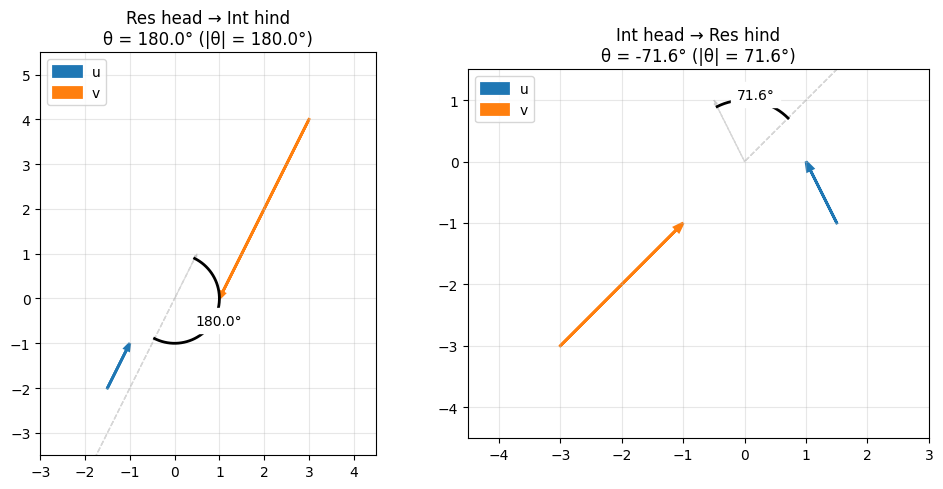

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def _signed_angle(u, v):
    """Return signed angle in degrees from u→v."""
    cross = u[0]*v[1] - u[1]*v[0]
    dot   = np.dot(u, v)
    return np.degrees(np.arctan2(cross, dot))

def _unit_arc(phi1, phi2, radius=1.0, npts=200):
    """Return points along the shortest arc from angle phi1→phi2."""
    delta = (phi2 - phi1 + np.pi) % (2*np.pi) - np.pi
    return np.linspace(phi1, phi1 + delta, npts)

def visualize_head_hind_comparison(
    nose_res, earL_res, earR_res, tail_res,
    nose_int, earL_int, earR_int, tail_int,
    arc_radius=1.0,
    figsize=(10,5)
):
    """
    Left panel: resident head‑vector anchored at ear midpoint,
                intruder hind‑vector anchored at tail.
    Right panel: intruder head‑vector anchored at ear midpoint,
                 resident hind‑vector anchored at tail.
    Also draws projections of both vectors at the origin for angle reference.
    """
    # convert to arrays
    nose_res, earL_res, earR_res, tail_res = map(np.array, (nose_res, earL_res, earR_res, tail_res))
    nose_int, earL_int, earR_int, tail_int = map(np.array, (nose_int, earL_int, earR_int, tail_int))

    # compute midpoints
    head_mid_res = (earL_res + earR_res) / 2
    head_mid_int = (earL_int + earR_int) / 2

    # vectors in world coords
    v_res_head = nose_res - head_mid_res
    v_int_hind = nose_int - tail_int

    v_int_head = nose_int - head_mid_int
    v_res_hind = nose_res - tail_res

    pairs = [
        (head_mid_res, v_res_head, tail_int, v_int_hind, "Res head → Int hind"),
        (head_mid_int, v_int_head, tail_res, v_res_hind, "Int head → Res hind")
    ]

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    for ax, (p_u, u, p_v, v, title) in zip(axes, pairs):
        # signed & abs angle
        θ = _signed_angle(u, v)
        absθ = abs(θ)

        # projection at origin
        ax.arrow(0, 0, u[0], u[1],
                 head_width=arc_radius*0.05, length_includes_head=True,
                 color="gray", alpha=0.3, linestyle='--')
        ax.arrow(0, 0, v[0], v[1],
                 head_width=arc_radius*0.05, length_includes_head=True,
                 color="gray", alpha=0.3, linestyle='--')

        # main arrows anchored at actual points
        ax.arrow(p_u[0], p_u[1], u[0], u[1],
                 head_width=arc_radius*0.1, length_includes_head=True,
                 color="tab:blue", lw=2, label="u")
        ax.arrow(p_v[0], p_v[1], v[0], v[1],
                 head_width=arc_radius*0.1, length_includes_head=True,
                 color="tab:orange", lw=2, label="v")

        # compute arc around origin
        φ1 = np.arctan2(u[1], u[0])
        φ2 = np.arctan2(v[1], v[0])
        thetas = _unit_arc(φ1, φ2, radius=arc_radius)

        xs = arc_radius * np.cos(thetas)
        ys = arc_radius * np.sin(thetas)
        ax.plot(xs, ys, color="black", lw=2)

        # annotate angle
        mid = φ1 + ((φ2 - φ1 + np.pi) % (2*np.pi) - np.pi) / 2
        tx, ty = (arc_radius+0.1)*np.cos(mid), (arc_radius+0.1)*np.sin(mid)
        ax.text(tx, ty, f"{absθ:.1f}°", ha="center", va="center",
                backgroundcolor="white")

        # set limits to encompass all arrows
        all_x = [0, p_u[0], p_u[0]+u[0], p_v[0], p_v[0]+v[0]]
        all_y = [0, p_u[1], p_u[1]+u[1], p_v[1], p_v[1]+v[1]]
        pad = arc_radius * 1.5
        ax.set_xlim(min(all_x)-pad, max(all_x)+pad)
        ax.set_ylim(min(all_y)-pad, max(all_y)+pad)

        ax.set_aspect("equal", "box")
        ax.set_title(f"{title}\nθ = {θ:.1f}° (|θ| = {absθ:.1f}°)")
        ax.legend(loc="upper left")
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


# ── example data ──
resident_nose   = [-1, -1]
resident_earL   = [-2, -2]
resident_earR   = [-1, -2]
resident_tail   = [-3, -3]

intruder_nose   = [1,  0]
intruder_earL   = [1, -1]
intruder_earR   = [2, -1]
intruder_tail   = [3,  4]

visualize_head_hind_comparison(
    resident_nose, resident_earL, resident_earR, resident_tail,
    intruder_nose, intruder_earL, intruder_earR, intruder_tail,
    arc_radius=1.0
)


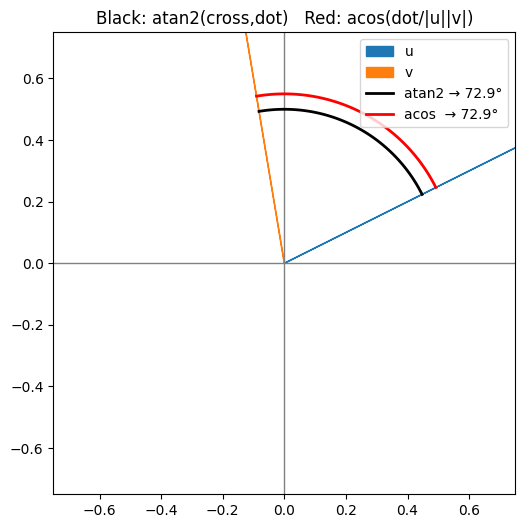

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_angle_comparison(u, v, arc_radius=0.5, figsize=(6,6)):
    """
    u, v : 2‐vectors (e.g. resident‐head and intruder‐hind)
    Draws:
      • black arc = signed‐angle via atan2(cross,dot)
      • red   arc = acos( clamp(dot/(||u||*||v||), -1,1) ), unsigned
    """
    # compute u→v via atan2
    cross = u[0]*v[1] - u[1]*v[0]
    dot   = np.dot(u, v)
    θ_atan2 = np.degrees(np.arctan2(cross, dot))
    abs_atan2 = abs(θ_atan2)

    # compute via acos of dot/(|u||v|)
    cosθ = dot / (np.linalg.norm(u)*np.linalg.norm(v))
    cosθ = np.clip(cosθ, -1, 1)
    θ_acos = np.degrees(np.arccos(cosθ))

    # angles for arcs
    φ1 = np.arctan2(u[1], u[0])
    φ2 = φ1 + np.deg2rad(θ_atan2)   # end of black arc
    thetas_black = np.linspace(φ1, φ2, 100)
    thetas_red   = np.linspace(φ1, φ1 + np.deg2rad(θ_acos), 100)

    fig, ax = plt.subplots(figsize=figsize)
    # faded axes
    ax.axhline(0, color='gray', lw=1); ax.axvline(0, color='gray', lw=1)

    # arrows at origin
    ax.arrow(0,0, u[0], u[1], head_width=0.05, length_includes_head=True, color='tab:blue', label='u')
    ax.arrow(0,0, v[0], v[1], head_width=0.05, length_includes_head=True, color='tab:orange', label='v')

    # black arc = atan2 version
    xb = arc_radius * np.cos(thetas_black)
    yb = arc_radius * np.sin(thetas_black)
    ax.plot(xb, yb, color='black', lw=2, label=f"atan2 → {abs_atan2:.1f}°")

    # red arc = acos version
    xar = arc_radius*1.1 * np.cos(thetas_red)
    yar = arc_radius*1.1 * np.sin(thetas_red)
    ax.plot(xar, yar, color='red', lw=2, label=f"acos  → {θ_acos:.1f}°")

    ax.set_aspect('equal', 'box')
    ax.set_xlim(-arc_radius*1.5, arc_radius*1.5)
    ax.set_ylim(-arc_radius*1.5, arc_radius*1.5)
    ax.legend(loc='upper right')
    ax.set_title("Black: atan2(cross,dot)   Red: acos(dot/|u||v|)")
    plt.show()

# example vectors
u = np.array([ 1.0,  0.5])   # e.g. resident head
v = np.array([-0.2,  1.2])   # e.g. intruder hind

visualize_angle_comparison(u, v)
